In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import numpy as np
import os, json, random, cv2
import matplotlib.pyplot as plt


In [2]:
def json_to_mask(mask_json, image_size):
    mask = np.zeros((image_size[1], image_size[0]), dtype=np.uint8)
    for shape in mask_json['shapes']:
        points = np.array(shape['points'], dtype=np.int32)
        cv2.fillPoly(mask, [points], 255)
    return mask

class CrackDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.files = [f for f in os.listdir(root_dir) if f.endswith('.jpg') and os.path.exists(os.path.join(root_dir, f.replace('.jpg', '.json')))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.files[idx])
        json_path = img_path.replace('.jpg', '.json')

        image = Image.open(img_path).convert("RGB")
        with open(json_path, 'r') as f:
            mask_json = json.load(f)
        mask = json_to_mask(mask_json, image.size)
        mask = Image.fromarray(mask)

        if self.transform:
            image, mask = self.transform(image, mask)

        return transforms.ToTensor()(image), transforms.ToTensor()(mask)

In [3]:
# Dataset & Transform
class PairedTransform:
    def __init__(self):
        self.transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(30),
        ])

    def __call__(self, image, mask):
        seed = np.random.randint(2147483647)
        random.seed(seed)
        torch.manual_seed(seed)
        image = self.transforms(image)

        random.seed(seed)
        torch.manual_seed(seed)
        mask = self.transforms(mask)
        return image, mask

In [4]:
class SimpleTransformerBlock(nn.Module):
    def __init__(self, in_channels, num_heads=4):
        super().__init__()
        self.norm = nn.LayerNorm(in_channels)
        self.attn = nn.MultiheadAttention(embed_dim=in_channels, num_heads=num_heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(in_channels, in_channels),
            nn.ReLU(),
            nn.Linear(in_channels, in_channels)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        x_flat = x.flatten(2).transpose(1, 2)  # (B, H*W, C)
        x_flat = self.norm(x_flat)
        attn_out, _ = self.attn(x_flat, x_flat, x_flat)
        x_flat = x_flat + attn_out
        x_flat = x_flat + self.ffn(x_flat)
        x = x_flat.transpose(1, 2).reshape(b, c, h, w)
        return x


In [5]:
class FPNEncoder(nn.Module):
    def __init__(self, backbone_name="resnet50", pretrained=True):
        super().__init__()
        resnet = getattr(models, backbone_name)(pretrained=pretrained)
        self.enc0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)  # 64, /2
        self.enc1 = nn.Sequential(resnet.maxpool, resnet.layer1)          # 64, /4
        self.enc2 = resnet.layer2                                         # 128, /8
        self.enc3 = resnet.layer3                                         # 256, /16
        self.enc4 = resnet.layer4                                         # 512, /32

    def forward(self, x):
        x0 = self.enc0(x)
        x1 = self.enc1(x0)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3)
        return [x0, x1, x2, x3, x4]  # multiscale features


In [6]:
class FPNDecoderTransformer(nn.Module):
    def __init__(self, channels, transformer_channels=512):
        super().__init__()
        self.transformer = SimpleTransformerBlock(transformer_channels)
        self.lateral4 = nn.Conv2d(channels[4], channels[3], 1)
        self.lateral3 = nn.Conv2d(channels[3], channels[2], 1)
        self.lateral2 = nn.Conv2d(channels[2], channels[1], 1)
        self.lateral1 = nn.Conv2d(channels[1], channels[0], 1)
        self.smooth3 = nn.Conv2d(channels[3], channels[3], 3, padding=1)
        self.smooth2 = nn.Conv2d(channels[2], channels[2], 3, padding=1)
        self.smooth1 = nn.Conv2d(channels[1], channels[1], 3, padding=1)

    def forward(self, features):
        x0, x1, x2, x3, x4 = features

        # Transformer on the deepest feature
        x4 = self.transformer(x4)  # (B, 512, 8, 8) for resnet34

        # FPN top-down pathway (always upsample, then add lateral)
        x4_upsampled = F.interpolate(self.lateral4(x4), size=x3.shape[2:], mode='nearest')
        x3 = x4_upsampled + x3
        x3 = self.smooth3(x3)

        x3_upsampled = F.interpolate(self.lateral3(x3), size=x2.shape[2:], mode='nearest')
        x2 = x3_upsampled + x2
        x2 = self.smooth2(x2)

        x2_upsampled = F.interpolate(self.lateral2(x2), size=x1.shape[2:], mode='nearest')
        x1 = x2_upsampled + x1
        x1 = self.smooth1(x1)

        x1_upsampled = F.interpolate(self.lateral1(x1), size=x0.shape[2:], mode='nearest')
        x0 = x1_upsampled + x0

        # Final upsampling to restore full resolution (assuming input is 256x256, x0 is now 128x128)
        x0 = F.interpolate(x0, scale_factor=2, mode='nearest')
        return x0


In [11]:
# ------------------- Final Model Class (Lite) ---------------------------------------
class FPNTransformerSegmentation(nn.Module):
    def __init__(self, backbone_name="resnet50"):
        super().__init__()
        self.encoder = FPNEncoder(backbone_name)
        # Set channel sizes dynamically
        if backbone_name in ["resnet18", "resnet34"]:
            channels = [64, 64, 128, 256, 512]
            transformer_channels = 512
        elif backbone_name in ["resnet50", "resnet101", "resnet152"]:
            channels = [64, 256, 512, 1024, 2048]
            transformer_channels = 2048
        else:
            raise ValueError(f"Unsupported backbone: {backbone_name}")

        self.decoder = FPNDecoderTransformer(channels, transformer_channels=transformer_channels)
        self.out_conv = nn.Conv2d(channels[0], 1, 1)

    def forward(self, x):
        feats = self.encoder(x)
        x = self.decoder(feats)
        x = self.out_conv(x)
        return x


Epoch 1/50, Train Loss: 0.0646, Val Loss: 0.0459
Epoch 2/50, Train Loss: 0.0424, Val Loss: 0.0424
Epoch 3/50, Train Loss: 0.0392, Val Loss: 0.0441
Epoch 4/50, Train Loss: 0.0376, Val Loss: 0.0419
Epoch 5/50, Train Loss: 4.9327, Val Loss: 0.1427
Epoch 6/50, Train Loss: 0.1331, Val Loss: 0.1273
Epoch 7/50, Train Loss: 0.1192, Val Loss: 0.1228
Epoch 8/50, Train Loss: 0.1185, Val Loss: 0.1141
Epoch 9/50, Train Loss: 0.1092, Val Loss: 0.1139
Epoch 10/50, Train Loss: 0.1030, Val Loss: 0.1081
Epoch 11/50, Train Loss: 0.0975, Val Loss: 0.1090
Epoch 12/50, Train Loss: 0.0899, Val Loss: 0.0899
Epoch 13/50, Train Loss: 0.0829, Val Loss: 0.0828
Epoch 14/50, Train Loss: 0.0771, Val Loss: 0.0785
Epoch 15/50, Train Loss: 0.0729, Val Loss: 0.0724
Epoch 16/50, Train Loss: 0.0682, Val Loss: 0.0710
Epoch 17/50, Train Loss: 0.0638, Val Loss: 0.0698
Epoch 18/50, Train Loss: 0.0603, Val Loss: 0.0637
Epoch 19/50, Train Loss: 0.0572, Val Loss: 0.0590
Epoch 20/50, Train Loss: 0.0544, Val Loss: 0.0540
Epoch 21/

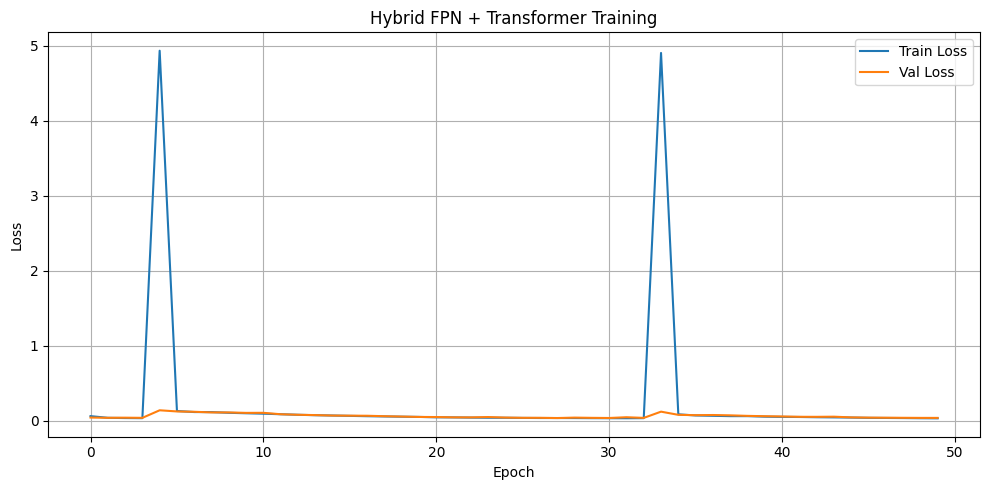

In [12]:
# --- Train ---
def train_model(model, train_loader, val_loader, device, epochs=25):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0
        for imgs, masks in train_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

        train_losses.append(running_train_loss / len(train_loader))

        model.eval()
        running_val_loss = 0
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, masks)
                running_val_loss += loss.item()
        val_losses.append(running_val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Hybrid FPN + Transformer Training")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model

# --- Run Everything ---
if __name__ == "__main__":
    root_dir = "/home/adityab/ADRL/final/Data"  # Replace with your path
    dataset = CrackDataset(root_dir, transform=PairedTransform())

    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=2, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FPNTransformerSegmentation(backbone_name="resnet50")  # or "resnet18", etc.
    trained_model = train_model(model, train_loader, val_loader, device, epochs=50)

Precision: 0.8143266266875038
Recall: 0.5614053162199836
F1 Score: 0.6646168241113427
Mean Dice Score: 0.659223739875526
Mean IoU Score: 0.5105989832521939


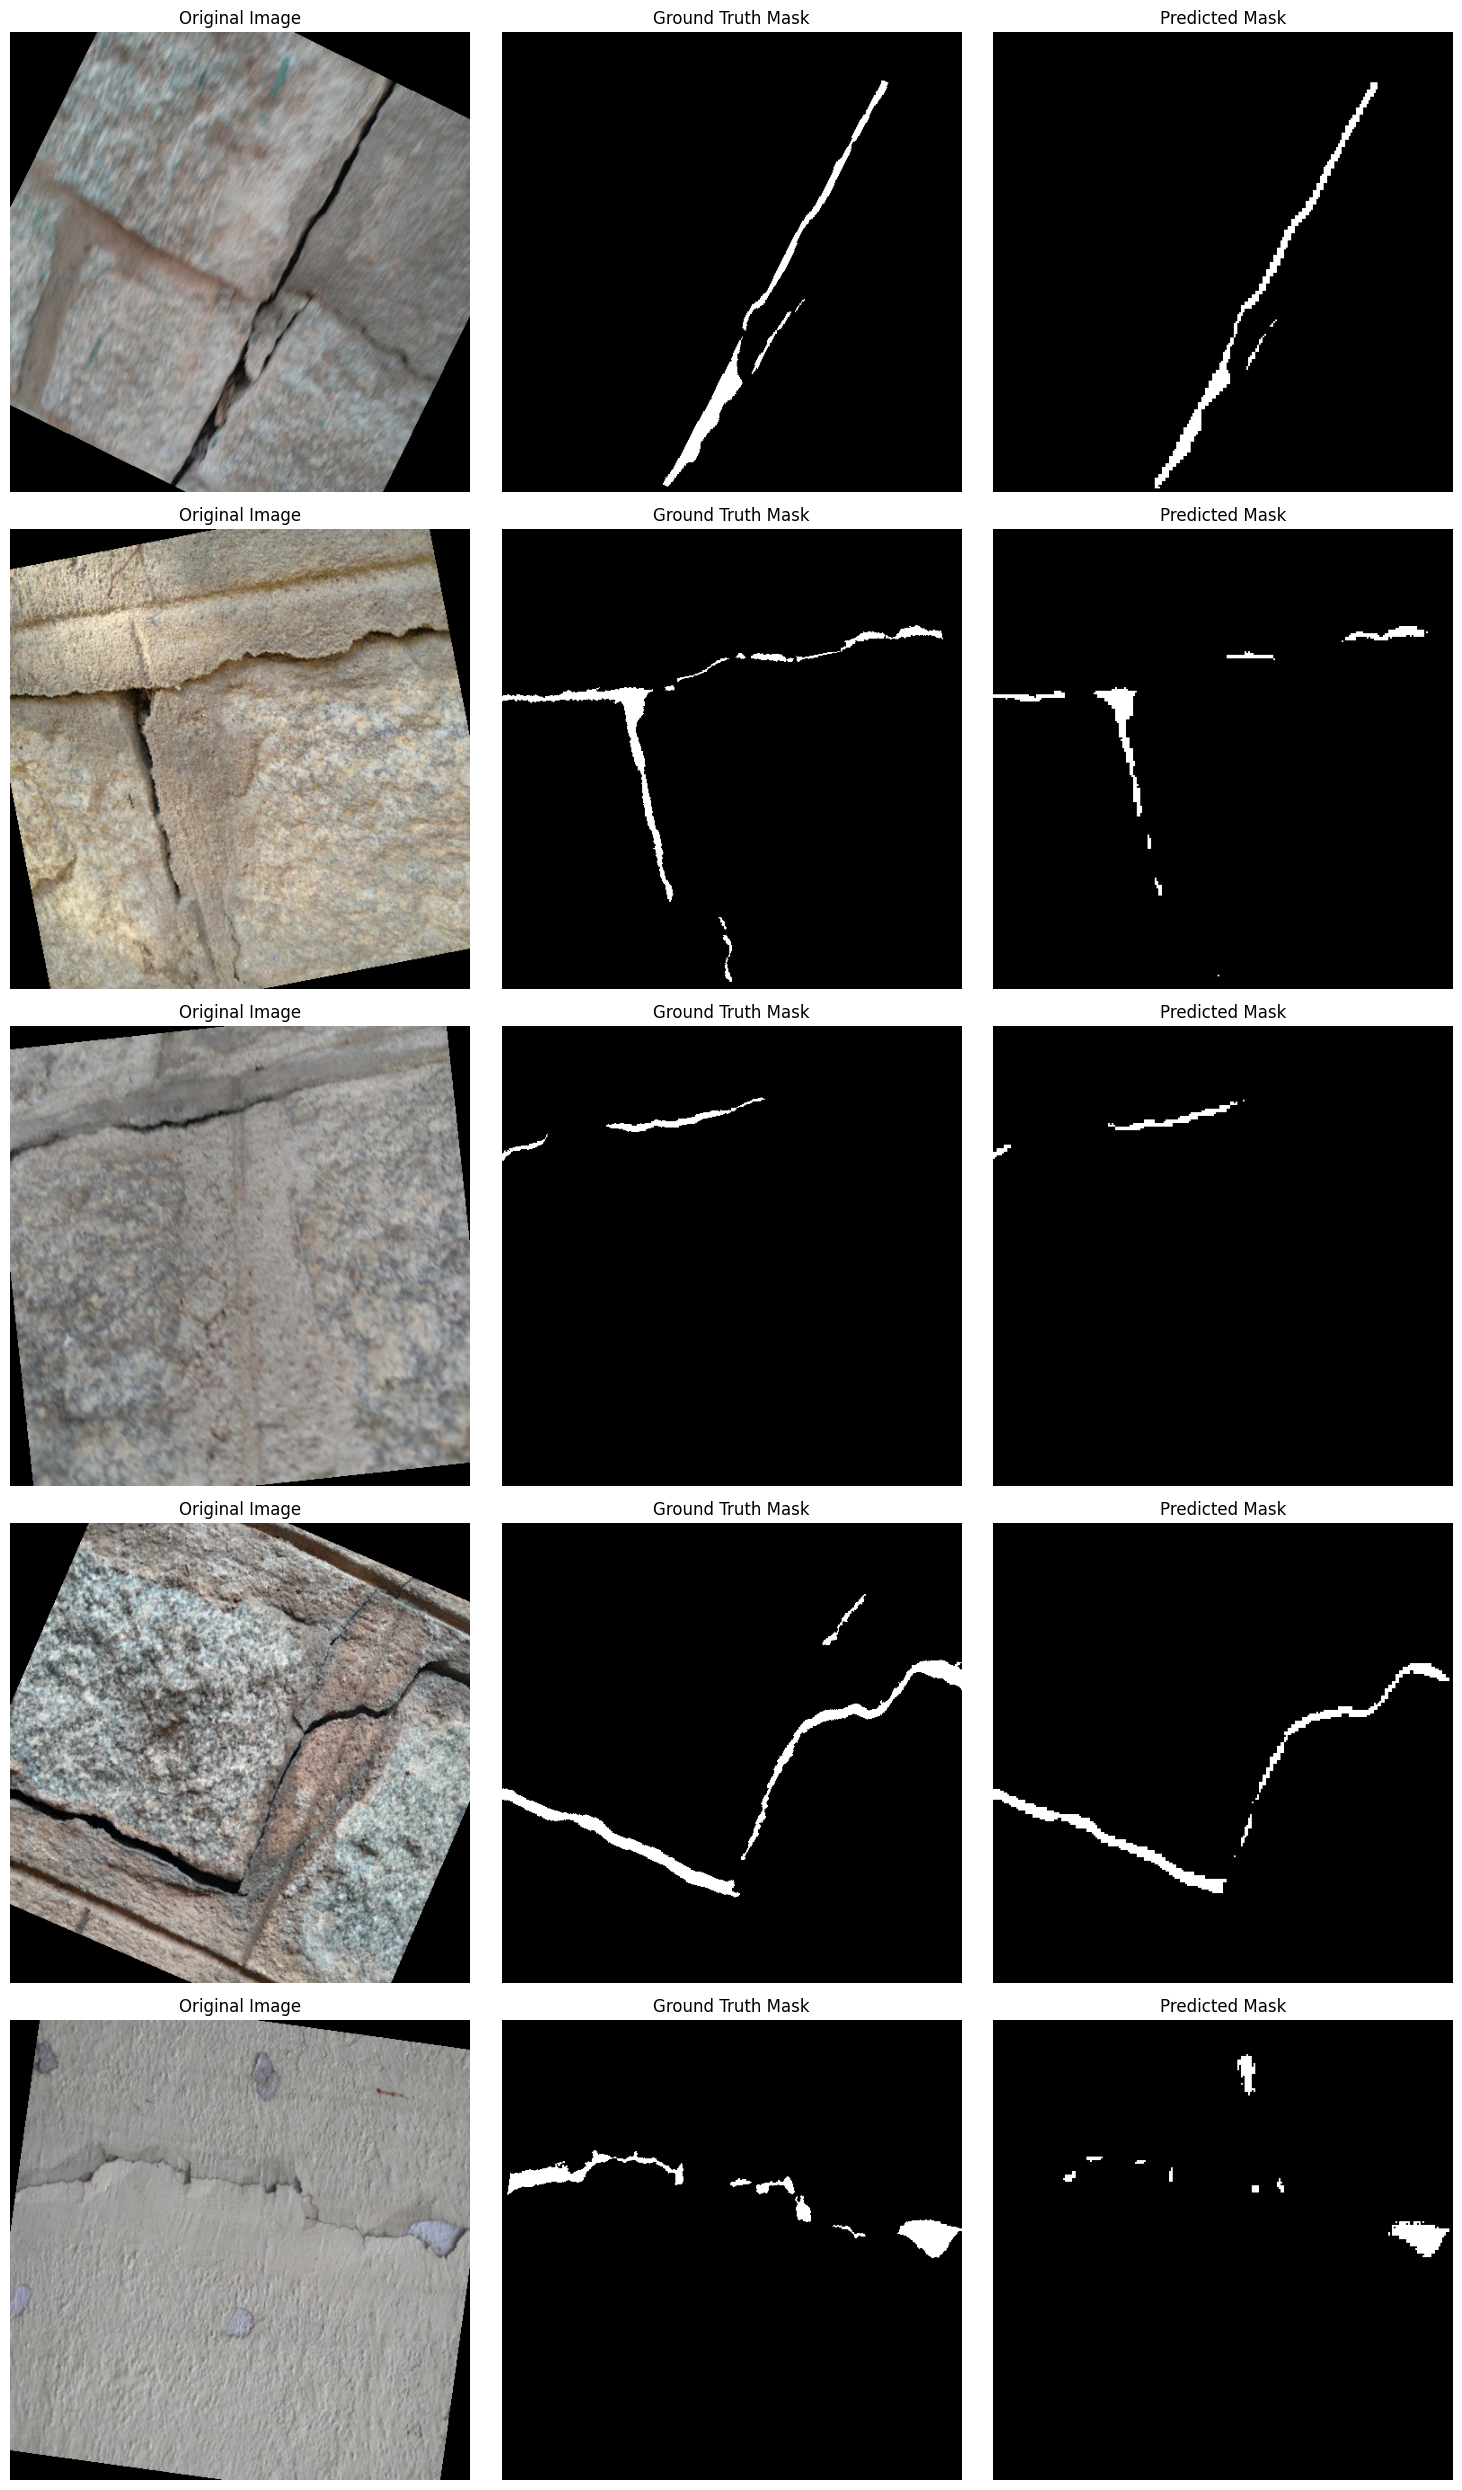

In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import random

# Helper metric functions
def dice_coefficient(pred, target, smooth=1.):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def iou_score(pred, target, smooth=1.):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

# Thresholding function
def binarize(tensor, threshold=0.5):
    return (tensor > threshold).float()

# Evaluate the model on test set
def evaluate_model(model, test_loader, device='cuda', threshold=0.5, num_images_to_display=5):
    model.eval()
    model.to(device)

    all_preds = []
    all_targets = []
    dice_scores = []
    iou_scores = []

    display_samples = []

    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            images, masks = images.to(device), masks.to(device)
            outputs = torch.sigmoid(model(images))
            preds = binarize(outputs, threshold)

            # Save for metrics
            all_preds.extend(preds.cpu().numpy().astype(np.uint8).flatten())
            all_targets.extend(masks.cpu().numpy().astype(np.uint8).flatten())

            dice_scores.append(dice_coefficient(preds, masks).item())
            iou_scores.append(iou_score(preds, masks).item())

            if len(display_samples) < num_images_to_display:
                display_samples.append((images.cpu(), masks.cpu(), preds.cpu()))

    # Classification metrics
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    mean_dice = np.mean(dice_scores)
    mean_iou = np.mean(iou_scores)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Mean Dice Score:", mean_dice)
    print("Mean IoU Score:", mean_iou)

    # Visualize 5 test samples
    fig, axs = plt.subplots(num_images_to_display, 3, figsize=(15, 5 * num_images_to_display))
    if num_images_to_display == 1:
        axs = [axs]

    for idx, (image, mask, pred) in enumerate(display_samples):
        img = np.transpose(image[0].numpy(), (1, 2, 0))
        axs[idx][0].imshow(img)
        axs[idx][0].set_title("Original Image")
        axs[idx][0].axis("off")

        axs[idx][1].imshow(mask[0][0].numpy(), cmap='gray')
        axs[idx][1].set_title("Ground Truth Mask")
        axs[idx][1].axis("off")

        axs[idx][2].imshow(pred[0][0].numpy(), cmap='gray')
        axs[idx][2].set_title("Predicted Mask")
        axs[idx][2].axis("off")

    plt.tight_layout()
    plt.show()

test_loader = DataLoader(test_ds, batch_size=2, shuffle=False)
# Run evaluation
evaluate_model(model=trained_model, test_loader=test_loader, device=device, threshold=0.5, num_images_to_display=5)

In [40]:

from sklearn.metrics import precision_score, recall_score, f1_score
import torchvision.transforms.functional as TF

def evaluate_metrics(model, dataloader, device, threshold=0.5, num_vis=5):
    model.eval()
    model.to(device)

    all_preds = []
    all_targets = []

    fig, axes = plt.subplots(num_vis, 3, figsize=(10, 3 * num_vis))

    with torch.no_grad():
        count = 0
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > threshold

            all_preds.append(preds.cpu().numpy())
            all_targets.append(masks.cpu().numpy())

            # --- Visualization ---
            if count < num_vis:
                for i in range(min(num_vis - count, images.size(0))):
                    img = TF.to_pil_image(images[i].cpu())
                    gt_mask = masks[i][0].cpu().numpy()
                    pred_mask = preds[i][0].cpu().numpy()

                    axes[count, 0].imshow(img)
                    axes[count, 0].set_title("Input")
                    axes[count, 1].imshow(gt_mask, cmap='gray')
                    axes[count, 1].set_title("Ground Truth")
                    axes[count, 2].imshow(pred_mask, cmap='gray')
                    axes[count, 2].set_title("Prediction")
                    for ax in axes[count]: ax.axis('off')
                    count += 1

    plt.tight_layout()
    plt.show()

    # --- Metrics ---
    y_true = np.concatenate(all_targets).flatten()
    y_pred = np.concatenate(all_preds).flatten()

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    dice = (2 * intersection) / (y_true.sum() + y_pred.sum())
    iou = intersection / union

    print(f"\n--- Evaluation Metrics ---")
    print(f"Precision:     {precision:.4f}")
    print(f"Recall:        {recall:.4f}")
    print(f"F1 Score:      {f1:.4f}")
    print(f"Mean Dice:     {dice:.4f}")
    print(f"Mean IoU:      {iou:.4f}")


In [ ]:
test_loader = DataLoader(test_ds, batch_size=2, shuffle=False)
evaluate_metrics(trained_model, test_loader, device)
